In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import Compose, ToTensor, RandomResizedCrop
from torchvision.datasets import CIFAR10, MNIST, Flowers102
from torch.utils.data import DataLoader

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cpu


# Create Dataset

In [ ]:
from utils.diffusionDataset import DiffusionDataset

image_size = (128, 128)
batch_size = 16
#variance_schedule = np.ones(20)*0.0011
variance_schedule = np.linspace(0, 2e-2, 1000)       # from Ho et al. (2020)
#alpha_t = np.cos((t/T+s)/(1+s)*np.pi/2)**2             # from Nichol & Dhariwal (2021)

In [3]:
# TRAIN

dataset_flowers_train = Flowers102(root='datasets', split='train',
                  download=True)

dataset_train = DiffusionDataset(data=dataset_flowers_train,
                           variance_schedule=variance_schedule,
                           transform=Compose([ToTensor(),
                                            RandomResizedCrop(image_size)]))

data_loader_train = DataLoader(dataset_train,
                         batch_size=batch_size,
                         pin_memory=True,
                         shuffle=True)

In [ ]:
# VAL

dataset_flowers_val = Flowers102(root='datasets', split='val',
                  download=True)

dataset_val = DiffusionDataset(data=dataset_flowers_val,
                           variance_schedule=variance_schedule,
                           transform=Compose([ToTensor(),
                                            RandomResizedCrop(image_size)]))

data_loader_val = DataLoader(dataset_val,
                         batch_size=batch_size,
                         pin_memory=True,
                         shuffle=True)

In [ ]:
# TEST

dataset_flowers_test = Flowers102(root='datasets', split='test',
                  download=True)

dataset_test = DiffusionDataset(data=dataset_flowers_test,
                           variance_schedule=variance_schedule,
                           transform=Compose([ToTensor(),
                                            RandomResizedCrop(image_size)]))

data_loader_test = DataLoader(dataset_test,
                         batch_size=batch_size,
                         pin_memory=True,
                         shuffle=True)

## Have a look at some elements in the dataset

Forward diffusion step at stage t = 157.


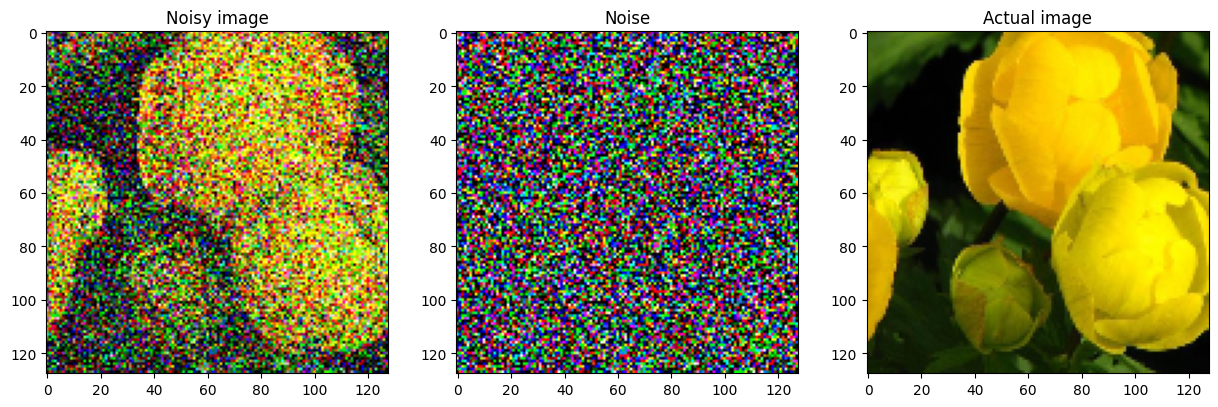

In [10]:
from utils.reconstruction import reconstruct_image_from_noise

(im_n, t), noise = next(iter(data_loader_train))
im_n = im_n[0]
t = t.numpy()[0]
noise = noise[0]

im = reconstruct_image_from_noise(im_n, noise, t, variance_schedule)

print(f"Forward diffusion step at stage t = {t}.")

w, h, dpi = 1500, 500, 100
fig, ax = plt.subplots(ncols=3, figsize=(w/dpi, h/dpi), dpi=dpi)

ax[0].imshow(im_n.permute(1, 2, 0).clip(0, 1))
ax[0].set_title('Noisy image')
ax[1].imshow(noise.permute(1, 2, 0).clip(0, 1))
ax[1].set_title('Noise')
ax[2].imshow(im.permute(1, 2, 0).clip(0, 1))
ax[2].set_title('Actual image')
plt.show()

## Plot the variance schedule and $\bar{\alpha}$

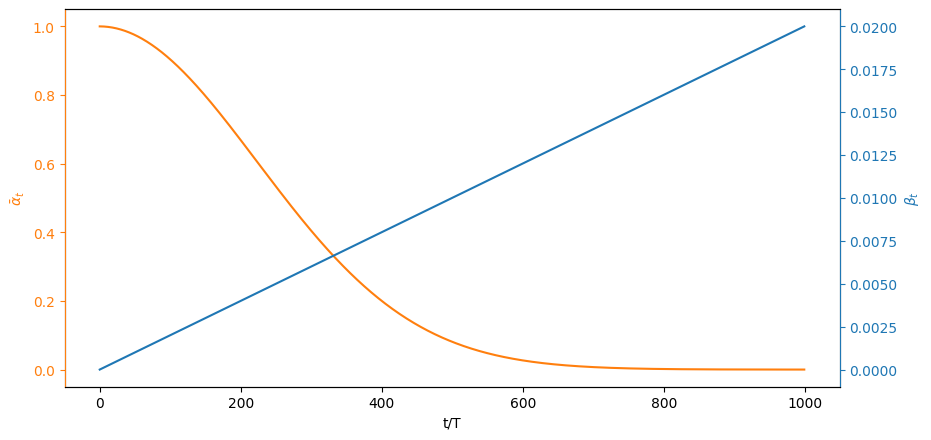

In [5]:
from utils.diffusionDataset import get_alpha_bar

T = 1000
t = np.arange(T+1)
s = 1e-3

alpha_bar = get_alpha_bar(variance_schedule)

w, h, dpi = 1000, 500, 100
fig, ax1 = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)
ax2 = ax1.twinx()

ax1.set_xlabel('t/T')

color = 'C1'
ax1.plot(alpha_bar, color=color)
ax1.set_ylabel(r'$\bar{\alpha}_t$', color=color)
ax2.spines['left'].set_color(color)
ax1.tick_params(axis='y', colors=color)

color = 'C0'
ax2.plot(variance_schedule, color=color)
ax2.set_ylabel(r'$\beta_t$', color=color)
ax2.spines['right'].set_color(color)
ax2.tick_params(axis='y', colors=color)

plt.show()

# Train Model

In [17]:
f'{type(net)}'.split('.')[-1][:-2]

'Unet'

In [4]:
(im_n, t), noise = next(iter(data_loader_train))
#im_n = im_n[0]
#t = t.numpy()[0]
#noise = noise[0]

"""noise_pred = net.forward(im_n, t)
noise_pred.shape"""

'noise_pred = net.forward(im_n, t)\nnoise_pred.shape'

In [16]:
from models.fourthModel import FourthModel
from torchsummary import summary

net = FourthModel(dim=128)

summary(net, input_data=(im_n, t))

torch.Size([16, 3, 128, 128])
torch.Size([16])
torch.Size([16, 512])
Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 84, 128, 128]        12,432
├─Sequential: 1-2                             [-1, 512]                 --
|    └─SinusoidalPositionEmbeddings: 2-1      [-1, 128]                 --
|    └─Linear: 2-2                            [-1, 512]                 66,048
|    └─GELU: 2-3                              [-1, 512]                 --
|    └─Linear: 2-4                            [-1, 512]                 262,656
├─ModuleList: 1                               []                        --
|    └─ModuleList: 2                          []                        --
|    |    └─ConvNextBlock: 3-1                [-1, 128, 128, 128]       547,684
|    |    └─ConvNextBlock: 3-2                [-1, 128, 128, 128]       663,040
|    |    └─Residual: 3-3                     [-1, 128, 128, 128]       66,176

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 84, 128, 128]        12,432
├─Sequential: 1-2                             [-1, 512]                 --
|    └─SinusoidalPositionEmbeddings: 2-1      [-1, 128]                 --
|    └─Linear: 2-2                            [-1, 512]                 66,048
|    └─GELU: 2-3                              [-1, 512]                 --
|    └─Linear: 2-4                            [-1, 512]                 262,656
├─ModuleList: 1                               []                        --
|    └─ModuleList: 2                          []                        --
|    |    └─ConvNextBlock: 3-1                [-1, 128, 128, 128]       547,684
|    |    └─ConvNextBlock: 3-2                [-1, 128, 128, 128]       663,040
|    |    └─Residual: 3-3                     [-1, 128, 128, 128]       66,176
|    |    └─Conv2d: 3-4                       [-1, 128, 64, 64]     

In [5]:
from models.fourthModel import FourthModel
from torchsummary import summary

net = FourthModel(dim=128, use_convnext=False, dim_mults=(1,2,4))

summary(net, input_data=(im_n, t))

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 84, 128, 128]        12,432
├─Sequential: 1-2                             [-1, 512]                 --
|    └─SinusoidalPositionEmbeddings: 2-1      [-1, 128]                 --
|    └─Linear: 2-2                            [-1, 512]                 66,048
|    └─GELU: 2-3                              [-1, 512]                 --
|    └─Linear: 2-4                            [-1, 512]                 262,656
├─ModuleList: 1                               []                        --
|    └─ModuleList: 2                          []                        --
|    |    └─ResnetBlock: 3-1                  [-1, 128, 128, 128]       321,536
|    |    └─ResnetBlock: 3-2                  [-1, 128, 128, 128]       361,344
|    |    └─Residual: 3-3                     [-1, 128, 128, 128]       66,176
|    |    └─Conv2d: 3-4                       [-1, 128, 64, 64]     

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 84, 128, 128]        12,432
├─Sequential: 1-2                             [-1, 512]                 --
|    └─SinusoidalPositionEmbeddings: 2-1      [-1, 128]                 --
|    └─Linear: 2-2                            [-1, 512]                 66,048
|    └─GELU: 2-3                              [-1, 512]                 --
|    └─Linear: 2-4                            [-1, 512]                 262,656
├─ModuleList: 1                               []                        --
|    └─ModuleList: 2                          []                        --
|    |    └─ResnetBlock: 3-1                  [-1, 128, 128, 128]       321,536
|    |    └─ResnetBlock: 3-2                  [-1, 128, 128, 128]       361,344
|    |    └─Residual: 3-3                     [-1, 128, 128, 128]       66,176
|    |    └─Conv2d: 3-4                       [-1, 128, 64, 64]     

In [6]:
from models.fourthModel import FourthModel
from torchsummary import summary

net = FourthModel(dim=128, use_convnext=True, dim_mults=(1,2,4))

summary(net, input_data=(im_n, t))

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 84, 128, 128]        12,432
├─Sequential: 1-2                             [-1, 512]                 --
|    └─SinusoidalPositionEmbeddings: 2-1      [-1, 128]                 --
|    └─Linear: 2-2                            [-1, 512]                 66,048
|    └─GELU: 2-3                              [-1, 512]                 --
|    └─Linear: 2-4                            [-1, 512]                 262,656
├─ModuleList: 1                               []                        --
|    └─ModuleList: 2                          []                        --
|    |    └─ConvNextBlock: 3-1                [-1, 128, 128, 128]       547,684
|    |    └─ConvNextBlock: 3-2                [-1, 128, 128, 128]       663,040
|    |    └─Residual: 3-3                     [-1, 128, 128, 128]       66,176
|    |    └─Conv2d: 3-4                       [-1, 128, 64, 64]     

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 84, 128, 128]        12,432
├─Sequential: 1-2                             [-1, 512]                 --
|    └─SinusoidalPositionEmbeddings: 2-1      [-1, 128]                 --
|    └─Linear: 2-2                            [-1, 512]                 66,048
|    └─GELU: 2-3                              [-1, 512]                 --
|    └─Linear: 2-4                            [-1, 512]                 262,656
├─ModuleList: 1                               []                        --
|    └─ModuleList: 2                          []                        --
|    |    └─ConvNextBlock: 3-1                [-1, 128, 128, 128]       547,684
|    |    └─ConvNextBlock: 3-2                [-1, 128, 128, 128]       663,040
|    |    └─Residual: 3-3                     [-1, 128, 128, 128]       66,176
|    |    └─Conv2d: 3-4                       [-1, 128, 64, 64]     

'noise_pred = net.forward(im_n, t)\nnoise_pred.shape'

In [ ]:
from models.firstModel import FirstModel
from models.secondModel import *
from models.fourthModel import Unet
from utils.training import train_model

net = SecondModelConcatFC(img_shape=(3,)+image_size, device=device)

epochs = 30
additional_info = {'batch_size': batch_size,
                   'image_size': image_size,
                   'variance_schedule': variance_schedule
                  }

checkpoint_dict = train_model(net=net,
                              data_loader_train=data_loader_train,
                              loss_function=torch.nn.MSELoss(),
                              epochs=epochs,
                              device=device,
                              checkpoint_folder='checkpoints/' + f'{type(net)}'.split('.')[-1][:-2],
                              clear_previous_checkpoints=True,
                              additional_info=additional_info)

plt.plot(checkpoint_dict['loss_history'], 'o-')
plt.yscale('log')

plt.show()

In [ ]:
np.argmin(checkpoint_dict['loss_history'])

# Test Performance

Get an image from the dataset

In [ ]:
image_size_test = (512, 512)
batch_size_test = 1

dataset_test = DiffusionDataset(data=dataset_flowers,
                                variance_schedule=variance_schedule,
                                transform=Compose([ToTensor(),
                                                   RandomResizedCrop(image_size_test)]))

data_loader_test = DataLoader(dataset_test,
                              batch_size=batch_size,
                              pin_memory=True,
                              shuffle=True)

In [ ]:
from utils.reconstruction import reconstruct_image_from_noise
from utils.eval import visualize_single_reconstruction

(noisy_image_batch, t_batch), noise_batch = next(iter(data_loader_test))
i = np.argmin(t_batch.numpy())

noisy_image = noisy_image_batch.numpy()[i]
t = t_batch.numpy()[i]
noise = noise_batch.numpy()[i]

# true original image
original_image = reconstruct_image_from_noise(noisy_image=noisy_image,
                                              noise=noise,
                                              t=t,
                                              variance_schedule=variance_schedule)

orig_name = "flower"

print(f't = {t}')

Get a benchmark image

In [ ]:
from matplotlib import image
from utils.diffusionDataset import get_alpha_bar
from utils.eval import visualize_single_reconstruction

original_image = np.asarray(image.imread('test_pictures/ship.jpg'), dtype=np.float32)/255
orig_name = "ship"

# original_image = np.asarray(image.imread('test_pictures/flower_1.jpg'), dtype=np.float32)/255
# orig_name = "flower_1"

#original_image = np.asarray(image.imread('test_pictures/flower_2.jpg'), dtype=np.float32)/255
#orig_name = "flower_2"

original_image = original_image.transpose(2, 0, 1)

image_size_test = original_image.shape[1:]

t = 25

a = get_alpha_bar(variance_schedule)[t]
noisy_image = np.sqrt(a)*original_image + np.sqrt(1-a)*np.random.normal(size=original_image.shape)
noisy_image = noisy_image.clip(0, 1)

# Model Comparisons on single images

## FirstModel

In [ ]:
from models.firstModel import FirstModel
from utils.eval import visualize_single_reconstruction, load_weights

net = FirstModel(img_shape=(3,)+image_size_test, device=device)
load_weights(net, 'checkpoints/FirstModel/checkpoint.ckpt')
net.to(device)

visualize_single_reconstruction(net, original_image, noisy_image, t, variance_schedule, device)

## SecondModelSum

In [ ]:
from models.secondModel import SecondModelSum
from utils.eval import visualize_single_reconstruction, load_weights

net = SecondModelSum(img_shape=(3,)+image_size_test, device=device)
load_weights(net, 'checkpoints/SecondModelSum/checkpoint.ckpt')
net.to(device)

visualize_single_reconstruction(net, original_image, noisy_image, t, variance_schedule, device)

## SecondModelConcat

In [ ]:
from models.secondModel import SecondModelConcat
from utils.eval import visualize_single_reconstruction, load_weights

net = SecondModelConcat(img_shape=(3,)+image_size_test, device=device)
net_name = f'{type(net)}'.split('.')[-1][:-2]

load_weights(net, f'checkpoints/{net_name}/checkpoint_0024_best.ckpt')
net.to(device)

output_folder = f'result_pictures/{net_name}_{orig_name}_{t}'
step = [1, 5]
visualize_single_reconstruction(net, original_image, noisy_image, t, variance_schedule, device, output_folder=output_folder, step=step)

## SecondModelConcatK2

In [ ]:
from models.secondModel import SecondModelConcatK2
from utils.eval import visualize_single_reconstruction, load_weights

net = SecondModelConcatK2(img_shape=(3,)+image_size_test, device=device)
net_name = f'{type(net)}'.split('.')[-1][:-2]

load_weights(net, f'checkpoints/{net_name}/checkpoint_0029_best.ckpt')
net.to(device)

output_folder = f'result_pictures/{net_name}_{orig_name}_{t}'
step = [1, 5]
visualize_single_reconstruction(net, original_image, noisy_image, t, variance_schedule, device, output_folder=output_folder, step=step)

## SecondModelConcatFC

In [ ]:
from models.secondModel import SecondModelConcatFC
from utils.eval import visualize_single_reconstruction, load_weights

net = SecondModelConcatFC(img_shape=(3,)+image_size_test, device=device)
net_name = f'{type(net)}'.split('.')[-1][:-2]

load_weights(net, f'checkpoints/{net_name}/checkpoint_0028_best.ckpt')
net.to(device)

output_folder = f'result_pictures/{net_name}_{orig_name}_{t}'
step = [1, 5]
visualize_single_reconstruction(net, original_image, noisy_image, t, variance_schedule, device, output_folder=output_folder, step=step)